In [1]:
import numpy as np
import spacy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sys
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read data.
f = open('../DATA1.txt', encoding = "ISO-8859-1")
x = f.readlines()
f.close()

In [3]:
# Parse data into emotions and sentences.
emotion = []
sentences = []

currIdx = 0
for line in x:
    # New entries have a tab \t
    slashIdx = line.find('\t')
    if slashIdx != -1:
        emotion.append(line[0:slashIdx])
        sentences.append(line[slashIdx+2:len(line)-2])
    else:
        sentences[currIdx] += ' ' + line[0:len(line)-2]
        if line.find('"') != -1:
            currIdx += 1

In [45]:
# Create documents for tf-idf, sentences by emotions.
# anger 0
# disgust 1096
# fear 2192
# guilt 3287
# joy 4380
# sadness 5474
# shame 6570
sentence_emo = ['','','','','','','']
for i in range(len(sentences)):
    if emotion[i] == 'anger':
        sentence_emo[0] += sentences[i] + ' '
    elif emotion[i] == 'disgust':
        sentence_emo[1] += sentences[i] + ' '
    elif emotion[i] == 'fear':
        sentence_emo[2] += sentences[i] + ' '
    elif emotion[i] == 'guilt':
        sentence_emo[3] += sentences[i] + ' '
    elif emotion[i] == 'joy':
        sentence_emo[4] += sentences[i] + ' '
    elif emotion[i] == 'sadness':
        sentence_emo[5] += sentences[i] + ' '
    elif emotion[i] == 'shame':
        sentence_emo[6] += sentences[i] + ' '
    else:
        print('error', emotion[i])

In [46]:
# Initialize tf-idf vectorizer.
tf = TfidfVectorizer(input='sentences_str6.txt', analyzer='word', stop_words = 'english', sublinear_tf=True)
tfidf_matrix =  tf.fit_transform(sentence_emo)
feature_names = tf.get_feature_names()

In [47]:
# Create lists for vocab and idfs by emotion.
all_tfidf_words = []
all_tfidf_idfs = []
for m in range(7):
    feature_index = tfidf_matrix[m,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[m, x] for x in feature_index])
    
    words_idf = []
    tfidf_words = []
    tfidf_idfs = []
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        if ' ' not in w:
            tfidf_words.append(w)
            tfidf_idfs.append(s)
            words_idf.append((w,s))
    all_tfidf_words.append(tfidf_words)
    all_tfidf_idfs.append(tfidf_idfs)

In [48]:
nlp = spacy.load("en")

# Find mean, max, min sentence vectors by averaging word vectors.
num_sentences = len(sentences)
len_vec = 384
means = np.zeros((num_sentences, len_vec))
maxs = np.zeros((num_sentences, len_vec))
mins = np.zeros((num_sentences, len_vec))
f1 = open("word_vec_tfidf.txt", "w+")
for j in range(len(sentences)):
    # Find emotion of current sentence.
    if emotion[j] == 'anger':
        emo_idx = 0
    elif emotion[j] == 'disgust':
        emo_idx = 1
    elif emotion[j] == 'fear':
        emo_idx = 2
    elif emotion[j] == 'guilt':
        emo_idx = 3
    elif emotion[j] == 'joy':
        emo_idx = 4
    elif emotion[j] == 'sadness':
        emo_idx = 5
    elif emotion[j] == 'shame':
        emo_idx = 6
    else:
        print('error', emotion[j])
    
    # Split sentences into tokens.
    sentences_tokens = nlp(sentences[j])
    word_vectors = np.zeros((200,len_vec))
    
    # Add relevant word vectors.
    counter = 0 # For counting number of relevant words
    for k in range(len(sentences_tokens)):
        word = sentences_tokens[k]
        if word.has_vector and (str(word) in all_tfidf_words[emo_idx]):
            word_idx = (all_tfidf_words[emo_idx]).index(str(word))
            # Multiply vector by tfidf.
            word_vectors[k,:] = word.vector * all_tfidf_idfs[emo_idx][word_idx]
            counter += 1
            
    # If none of the words are relevant
    if counter == 0:
        means[j,:] = np.sum(word_vectors, axis=0) 
    else:
        means[j,:] = np.sum(word_vectors, axis=0) / float(counter)
    maxs[j,:] = np.max(word_vectors, axis=0)
    mins[j,:] = np.min(word_vectors, axis=0)

    # Write mean of vectors to file.
    f1.write('[')
    for jj in range(len(means[j])):
        f1.write(str(means[j][jj]) + ', ')
    f1.write(emotion[j] + '],\n')
f1.close()

In [55]:
# Run PCA.
pca = PCA(n_components=2)
sentences_vecs_transformed = pca.fit_transform(means)
sentences_vecs_transformed1 = np.c_[emotion, sentences_vecs_transformed]

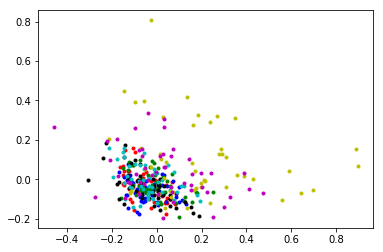

In [56]:
# Plot 50 points from each emotion.
# anger 0
# disgust 1096
# fear 2192
# guilt 3287
# joy 4380
# sadness 5474
# shame 6570
plt.plot(sentences_vecs_transformed[:50,0], sentences_vecs_transformed[:50,1], 'r.') # anger
plt.plot(sentences_vecs_transformed[1100:1150,0], sentences_vecs_transformed[1100:1150,1], 'b.') # disgust
plt.plot(sentences_vecs_transformed[2200:2250,0], sentences_vecs_transformed[2200:2250,1], 'g.') # fear
plt.plot(sentences_vecs_transformed[3300:3350,0], sentences_vecs_transformed[3300:3350,1], 'k.') # guilt
plt.plot(sentences_vecs_transformed[4400:4450,0], sentences_vecs_transformed[4400:4450,1], 'c.') # joy
plt.plot(sentences_vecs_transformed[5500:5550,0], sentences_vecs_transformed[5500:5550,1], 'y.') # sadness
plt.plot(sentences_vecs_transformed[7000:7050,0], sentences_vecs_transformed[7000:7050,1], 'm.') # shame
plt.show()